This Notebook is preparing the features that can be consumed by Machine Learning models.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='ticks')
sns.set_context("notebook", font_scale=1)
sns.set_style("darkgrid")


import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import date

%matplotlib inline

## Get the Patients Data

In [2]:
patients = pd.read_csv("./data/Patient.csv")
patients.head(2)

,PatientGuid,Gender,YearOfBirth,State,PracticeGuid
0,BC78C551-C20F-4F10-8D61-002AA9834BDE,F,1981,NY,3E08ED81-B9A1-4525-8308-0E991BCFA87F
1,6D88901A-3214-4BC0-B139-002EF1A5FA09,M,1937,SD,7BF4DAD8-5F67-4985-B911-20C9E89A3737


## Load Diagnosis Data

In [3]:
diagnosis = pd.read_csv("./data/Diagnosis.csv")
diagnosis.head(2)

,DiagnosisGuid,PatientGuid,ICD9Code,DiagnosisDescription,StartYear,StopYear,Acute,UserGuid
0,AD58C335-C62E-4E4C-A5C9-00005C89DA06,44C0A13A-C841-4063-A2A7-CFADA3785F23,V70.0,Routine general medical examination at a healt...,2010,NaN,0,7511BCEC-9E46-4808-99A7-5B30778B6E84
1,74D1CE08-CD1E-4199-86D3-0001AED0AB24,F2B45907-C559-4077-B2FE-04F354DAB00D,719.45,Pain in joint involving pelvic region and thigh,0,NaN,0,4773B833-9CD4-41E8-895B-846DC1EA7279


#### Identify patients who have Acid Reflux

In [4]:
patients_with_Acid_Reflux = diagnosis[diagnosis.ICD9Code == "530.81"]["PatientGuid"].unique()
patients_with_Acid_Reflux.shape

(618,)

#### Flag patients who are diagnosed with Acid Reflux

For classification training through machine learning model, all the patients, who are diagnosed with acid reflex, are flagged with 1. Other patients are flagged with 0.

In [5]:
def does_patient_have_acid_reflux(row):
    
    if row['PatientGuid'] in patients_with_Acid_Reflux:
        return 1
    else:
        return 0

patients['acid_reflux_patient'] = patients.apply (does_patient_have_acid_reflux,axis=1)

#### Drop all the columns that's not needed for machine learning model

For first machine learning model, only medication type will be used. Drop all the columns that's not needed for machine learning models

In [6]:
patients = patients[["PatientGuid","acid_reflux_patient"]]
patients.head(2)

,PatientGuid,acid_reflux_patient
0,BC78C551-C20F-4F10-8D61-002AA9834BDE,0
1,6D88901A-3214-4BC0-B139-002EF1A5FA09,0


In [7]:
patients.to_csv("./features/patients_acid_reflux_outcome.csv",index=False)

#### Breakdown of data by outcome (i.e. Acid Reflux patients vs Non Acid Reflux patients)

In [8]:
### Function to calculate percentage for pie chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

Text(0,0.5,'')

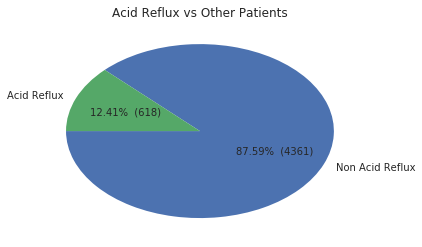

In [9]:
labels = 'Non Acid Reflux','Acid Reflux'
ax = patients.acid_reflux_patient.value_counts().plot.pie(autopct=make_autopct(patients.acid_reflux_patient.value_counts()),startangle = 180,title='Acid Reflux vs Other Patients',labels=labels)
ax.set_ylabel('')

## Load Medications data

In [10]:
medicines = pd.read_csv("./data/Medication.csv")
medicines.head(2)

,MedicationGuid,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule,DiagnosisGuid,UserGuid
0,6B6B34D1-8F67-4804-9493-0002123D0D2F,070A6571-6DAA-4F1B-8B0C-84C204CC26A6,00378710177,Fenofibrate oral tablet,160 mg,NaN,93EE54EE-BA6D-474C-8125-17188579D5AD,263EF64B-D26D-4842-BA47-32D09692AA90
1,2C82278D-C7D2-4258-B9AC-000374032F46,78D10955-1AF3-4DFF-A678-FA5B5597C888,00406055262,OxyCODONE Hydrochloride (oxyCODONE) oral tablet,5 mg,2.0,46F8ADBC-BC84-4108-9B53-4B9F55D5E2C3,D6537F06-58E0-4961-8466-920615561CD9


## Start Building the Feature with MedicationName

#### Drop fields that's not needed for Machine Learning Models

Following fields are not needed as they don't describe the medicine type -

1. MedicationGuid
  

2. DiagnosisGuid - Although combination of medicine and diagnosis could be interesting feature for Acid Reflux prediction (i.e. it may be possible that when a medicine is being administred for certain diagnosis, it's causing Acid Reflux). Something to experiment for future. For the first version of Machine Learning Model, I am dropping this feature. 
  

3. UserGuid

In [11]:
medicines = medicines[["PatientGuid","NdcCode","MedicationName","MedicationStrength","Schedule"]]
medicines.head(2)

,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule
0,070A6571-6DAA-4F1B-8B0C-84C204CC26A6,00378710177,Fenofibrate oral tablet,160 mg,NaN
1,78D10955-1AF3-4DFF-A678-FA5B5597C888,00406055262,OxyCODONE Hydrochloride (oxyCODONE) oral tablet,5 mg,2.0


#### Let's analyze each feature one bye one -

During the data analysis, we noticed that there was one to many mapping between MedicationName and NdcCode. Now question is - which feature should we use for machine learning model?

We can use NDC Code or we can use Medication Name or we can use a different 3rd party medicine categorization system (For example, American Hospital Formulary System (AHFS) Classification. AHFS groups NDC Codes into 165 categories. More information on AHFS available at http://www.ahfsdruginformation.com/). In order to finalize right feature for medicine, we will need to have more discussion. Also, we will need to experiment by building several machine learning models with different combinations to see which options work the best.

For first version of the model, I believe that following option is a reasonable option (we can have more discussion on this during presentation) -


-  __Use NdcCode -__ Note that NDC Code consists of 3 segments -  the labeler, the product, and the commercial package size. The first set of numbers in the NDC identifies the labeler (manufacturer, repackager, or distributer). The second set of numbers is the product code,which identifies the specific strength, dosage form (i.e, capsule, tablet, liquid) and formulation of a drug for a specific manufacturer. Finally, the third set is the package code, which identifies package sizes and types. The labeler code is assigned by the FDA, while the product and package code are assigned by the labeler. 
    
    So, if we want to test out if medicine of certain manufacturer has an issue or certain type of dosage can cause problems, then NdcCode could be a good indicator of it.

     

-  __Use MedicationName - __ Medication name could be a good indicator of type of medication, but this may not be a perfect field as well. For example, "Acyclovir oral capsule" and "Acyclovir oral tablet" are 2 separate medication names, but they may be same type of medication. Having said that, this will be a good feature to start with for the first version of Machine Learning model.
      


#### MedicationStrength

Let's look at MedicationStrength and Schedule to see if we could use them as feature.

In [12]:
medicines.MedicationStrength.describe()

count     21904
unique      698
top       10 mg
freq       1716
Name: MedicationStrength, dtype: object

In [13]:
medicines.shape

(21967, 5)

There are a good number (21904 and 21967) of Medication Strength data available. So, it makes total sense to use this as a feature.

Although, medication strength by itselef may not make sense as features. Medication strength has to be in a conext of medicine. So, let's look at them along with Medication Name and NDC Code.

In [14]:
Medication_strength_count_by_medicine_name = medicines.groupby(["MedicationName"])["MedicationStrength"].nunique().sort_values(ascending=False)
Medication_strength_count_by_medicine_name = Medication_strength_count_by_medicine_name[Medication_strength_count_by_medicine_name>1]
Medication_strength_count_by_medicine_name.head(20)

MedicationName
Synthroid (levothyroxine) oral tablet                                           12
Levothyroxine Sodium (levothyroxine) oral tablet                                11
Levoxyl (levothyroxine) oral tablet                                             10
Acetaminophen-HYDROcodone Bitartrate (acetaminophen-HYDROcodone) oral tablet     9
Levothroid (levothyroxine) oral tablet                                           8
Coumadin (warfarin) oral tablet                                                  8
Warfarin Sodium (warfarin) oral tablet                                           8
Lyrica (pregabalin) oral capsule                                                 8
MS Contin (morphine) oral tablet, extended release                               8
Morphine Sulfate ER (morphine) oral tablet, extended release                     7
Caduet (amLODIPine-atorvastatin) oral tablet                                     6
Lisinopril oral tablet                                                  

___Note that there are 503 medications with different types of strength. Now, let's look at how that data looks.___

Now, let's look at some of the medication names with multiple strength.

In [15]:
strength_by_medication_name = medicines[medicines.MedicationName.isin(Medication_strength_count_by_medicine_name.index)]
strength_by_medication_name = strength_by_medication_name.groupby(["MedicationName","MedicationStrength"]).size()
strength_by_medication_name.head(30)

MedicationName                                                                MedicationStrength
AVINza (morphine) oral capsule, extended release                              60 mg/24 hours         1
                                                                              90 mg/24 hours         2
Abilify (ARIPiprazole) oral tablet                                            10 mg                  6
                                                                              15 mg                  7
                                                                              2 mg                   9
                                                                              20 mg                  1
                                                                              30 mg                  1
                                                                              5 mg                  11
Accupril (quinapril) oral tablet                                              1

When we look at Medication Name and Medication Strength this way, it makes sense to combine them together to make a single feature. So for example - "Acyclovir oral tablet 400 mg" will be one feature and "Acyclovir oral tablet 800 mg" will be other feature.


#### Combine medication name and medication strength together

In [16]:
## Replace spaces in medication name with _
medicines.MedicationName = medicines.MedicationName.str.replace(" ","_")

##Replace null value in Medication Strength with empty string
medicines.MedicationStrength = medicines.MedicationStrength.fillna("")

medicines["MedicationName_with_stregth"] = medicines.MedicationName.astype(str) + "-" + medicines.MedicationStrength
medicines.head(5)

,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule,MedicationName_with_stregth
0,070A6571-6DAA-4F1B-8B0C-84C204CC26A6,00378710177,Fenofibrate_oral_tablet,160 mg,NaN,Fenofibrate_oral_tablet-160 mg
1,78D10955-1AF3-4DFF-A678-FA5B5597C888,00406055262,OxyCODONE_Hydrochloride_(oxyCODONE)_oral_tablet,5 mg,2.0,OxyCODONE_Hydrochloride_(oxyCODONE)_oral_table...
2,5BD620F9-6CFB-47E5-B263-2F983EAA2837,66860008603,Ketorolac_Tromethamine_(ketorolac)_injectable_...,30 mg/mL,NaN,Ketorolac_Tromethamine_(ketorolac)_injectable_...
3,8A91FD67-0C5D-4327-9103-396414264790,58016041060,Flomax_(tamsulosin)_oral_capsule,0.4 mg,NaN,Flomax_(tamsulosin)_oral_capsule-0.4 mg
4,2435551F-E88B-483F-9177-CC5817A47404,54868371800,Flonase_(fluticasone_nasal)_nasal_spray,0.05 mg/inh,NaN,Flonase_(fluticasone_nasal)_nasal_spray-0.05 m...


#### Now, let's look at NDC Code and medicine strength together the same way

In [17]:
Medication_strength_count_by_NdcCode = medicines.groupby(["NdcCode"])["MedicationStrength"].nunique().sort_values(ascending=False)
Medication_strength_count_by_NdcCode = Medication_strength_count_by_NdcCode[Medication_strength_count_by_NdcCode>1]
Medication_strength_count_by_NdcCode.head(20)

NdcCode
54868481000    3
68115077615    2
00597008717    2
00093002301    2
53885039310    2
00223058205    2
00034051610    2
00406145101    2
00182188701    2
00378212001    2
68115083560    2
00223197101    2
00093550201    2
00115014001    2
00051845030    2
00093224001    2
00093314701    2
00093314705    2
00037024330    2
49348065112    2
Name: MedicationStrength, dtype: int64

Even thought NDC Code has strength information included in it's naming convention, it appears that NDC code also has multiple strengths. Let's look at some data point.

In [18]:
strength_by_NDC_Code = medicines[medicines.NdcCode.isin(Medication_strength_count_by_NdcCode.index)]
strength_by_NDC_Code = strength_by_NDC_Code.groupby(["NdcCode","MedicationStrength"]).size()
strength_by_NDC_Code.head(30)

NdcCode      MedicationStrength  
00034051610  60 mg                    1
             60 mg/12 hours           1
00037024330  0.15%                    2
             205.5 mcg/inh           19
00051845030  1%                       2
             50 mg/5 g                1
00081013555  150 mg                   2
             150 mg/12 hours          2
00093002301  120 mg                   1
             120 mg/12 hours          1
00093224001  500 mg                   2
             monohydrate 500 mg       2
00093314701  500 mg                   1
             monohydrate 500 mg       9
00093314705  500 mg                   1
             monohydrate 500 mg       4
00093550201  150 mg                   2
             150 mg/12 hours          1
00115014001  50,000 intl units       16
             50000 intl units         1
00172640544  0.083%                   9
             2.5 mg/3 mL (0.083%)     4
00173013555  150 mg                   4
             150 mg/12 hours          1
001821

___Looking at above data, it appears that a single NDC Code doesn't have different strength. But, the string for strength is not consistent across different rows. In order to get optimum results from Machine Learning models, we will need to do some data clean up for MedicationStrength string. For first version of the model, I will leave the string as is. I will get to it later.___

___Also based upon the data minining, it appears that there is no need to combine strength into NDC Code.___


#### Now let's look at Schedule feature

In [19]:
medicines.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PatientGuid,21967,4940,A79241F6-3D8E-4208-B64E-7C2591F72398,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NdcCode,21967,6359,00069306075,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MedicationName,21895,1925,Lisinopril_oral_tablet,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MedicationStrength,21967,699,10 mg,1716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Schedule,2507,NaN,NaN,NaN,3.38931,0.912368,2,3,4,4,5
MedicationName_with_stregth,21967,2846,Zithromax_Z-Pak_(azithromycin)_oral_tablet-250 mg,244,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that schedule is available only for 2507 medications (~10%). Also, there is no way to define good default value in the rows that have missing data on schedule. We potentially can figure out default schedule for each medication and fill the data. That will require some research and assistance from a domain expert - I will drop Schedule as feature for now.

#### Drop the columns that's not needed

In [20]:
medicines.head(2)

,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule,MedicationName_with_stregth
0,070A6571-6DAA-4F1B-8B0C-84C204CC26A6,00378710177,Fenofibrate_oral_tablet,160 mg,NaN,Fenofibrate_oral_tablet-160 mg
1,78D10955-1AF3-4DFF-A678-FA5B5597C888,00406055262,OxyCODONE_Hydrochloride_(oxyCODONE)_oral_tablet,5 mg,2.0,OxyCODONE_Hydrochloride_(oxyCODONE)_oral_table...


In [21]:
#medicines = medicines[["PatientGuid","NdcCode","MedicationName","MedicationStrength"]]
#medicines.MedicationName = medicines.MedicationName.fillna('NaN')
#medicines.MedicationName = medicines.MedicationName.astype(str)
#medicines.MedicationStrength = medicines.MedicationStrength.astype(str)
medicines = medicines[["PatientGuid","NdcCode","MedicationName_with_stregth"]]
medicines.head(2)

,PatientGuid,NdcCode,MedicationName_with_stregth
0,070A6571-6DAA-4F1B-8B0C-84C204CC26A6,00378710177,Fenofibrate_oral_tablet-160 mg
1,78D10955-1AF3-4DFF-A678-FA5B5597C888,00406055262,OxyCODONE_Hydrochloride_(oxyCODONE)_oral_table...


#### Convert NDCCode and MedicationName_with_strength into numeric feature

Following process will be followed to convert NDCCode and MedicationName_with_strenght into feature

1. Patient are taking multiple medications. As a result, medicine dataset has multiple rows for patients. Multiple rows of patients will be merged together to create a single row.

2. In several instances, patient is associated with medicines multiple times. As we merge the rows together, we keep the count of number of times patient has taken certain medications.

___Note ideal would have been to build a time series feature of medicines if we had the timedata available for medicines. But since we don't have that data, we will just assign binary flag for each of the medications.___

In [22]:
medicine_finalized_features = pd.DataFrame()
for column in medicines.iloc[:,1:].columns:
    print ("column name is: " + column)
    medicine_feature = medicines.groupby(['PatientGuid',column]).size()
    medicine_feature = medicine_feature.reset_index()
    print (medicine_feature.shape)
    medicine_feature.rename(columns={0:(column + "_count")},inplace=True)
    medicine_feature = pd.pivot_table(medicine_feature, \
                                                   index=['PatientGuid'], \
                                                  columns=column,values= (column+'_count'))
    medicine_feature = medicine_feature.reset_index()
    medicine_feature = medicine_feature.fillna(0)
    print (medicine_feature.shape)
    cols_to_use = medicine_feature.columns.difference(medicine_finalized_features.columns)
    medicine_finalized_features = pd.concat([medicine_finalized_features,medicine_feature],axis=1)
    medicine_finalized_features = medicine_finalized_features.fillna(0)
    del medicine_feature
    

column name is: NdcCode
(21628, 3)
(4940, 6360)
column name is: MedicationName_with_stregth
(21317, 3)
(4940, 2847)


In [23]:
medicine_finalized_features.shape

(4940, 9207)

#### Remove some of the columns where Medicantion Name was Null

In [24]:
for column in medicine_finalized_features:
    if column.find('nan-') != -1:
        print (column)
        medicine_finalized_features.drop([column],inplace=True,axis=1)

nan-
nan--


In [25]:
medicine_finalized_features.shape

(4940, 9205)

#### Remove duplicate columns

There are 2 PatientGuid Columns (came duing concatenation). Drop one of them.

In [26]:
_, i = np.unique(medicine_finalized_features.columns, return_index=True)
medicine_finalized_features = medicine_finalized_features.iloc[:, i]

In [27]:
medicine_feature_columns = list(medicine_finalized_features.columns.values)
medicine_feature_columns.remove("PatientGuid")
medicine_feature_columns.insert(0, "PatientGuid")
medicine_finalized_features = medicine_finalized_features[medicine_feature_columns]
medicine_finalized_features.head(2)


,PatientGuid,00002034603,00002036302,00002036303,00002036333,00002036343,00002080302,00002080303,00002109402,00002109502,...,Zylet_(loteprednol-tobramycin_ophthalmic)_ophthalmic_suspension-0.5%-0.3%,Zymar_(gatifloxacin_ophthalmic)_ophthalmic_solution-0.3%,"ZyrTEC-D_(cetirizine-pseudoephedrine)_oral_tablet,_extended_release-5 mg-120 mg","ZyrTEC_(cetirizine)_oral_tablet,_chewable-10 mg",ZyrTEC_(cetirizine)_oral_tablet-10 mg,ZyrTEC_Hives_(cetirizine)_oral_tablet-10 mg,Zyvox_(linezolid)_oral_tablet-600 mg,alli_(orlistat)_oral_capsule-60 mg,depo-subQ_provera_104_(medroxyPROGESTERone)_subcutaneous_suspension-104 mg/0.65 mL,optive_(ocular_lubricant)_ophthalmic_solution--
0,00033D2D-D57C-48A7-B201-F9183F6E640B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00044CC1-7911-4C35-B73C-B5623FA3A60F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
medicine_finalized_features.shape

(4940, 9204)

#### Append the Outcome into the featureset

In [29]:
patients.head(2)

,PatientGuid,acid_reflux_patient
0,BC78C551-C20F-4F10-8D61-002AA9834BDE,0
1,6D88901A-3214-4BC0-B139-002EF1A5FA09,0


In [30]:
medicine_finalized_features = pd.merge(medicine_finalized_features, patients,on=["PatientGuid"],how='left')

In [31]:
medicine_finalized_features.shape

(4940, 9205)

In [32]:
medicine_finalized_features.head(2)

,PatientGuid,00002034603,00002036302,00002036303,00002036333,00002036343,00002080302,00002080303,00002109402,00002109502,...,Zymar_(gatifloxacin_ophthalmic)_ophthalmic_solution-0.3%,"ZyrTEC-D_(cetirizine-pseudoephedrine)_oral_tablet,_extended_release-5 mg-120 mg","ZyrTEC_(cetirizine)_oral_tablet,_chewable-10 mg",ZyrTEC_(cetirizine)_oral_tablet-10 mg,ZyrTEC_Hives_(cetirizine)_oral_tablet-10 mg,Zyvox_(linezolid)_oral_tablet-600 mg,alli_(orlistat)_oral_capsule-60 mg,depo-subQ_provera_104_(medroxyPROGESTERone)_subcutaneous_suspension-104 mg/0.65 mL,optive_(ocular_lubricant)_ophthalmic_solution--,acid_reflux_patient
0,00033D2D-D57C-48A7-B201-F9183F6E640B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,00044CC1-7911-4C35-B73C-B5623FA3A60F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Save the finalized feature to use with Machine Learning Models

In [33]:
medicine_finalized_features.to_csv("./features/medicine_finalized_features.csv",index=False)